<a href="https://colab.research.google.com/github/sowmyarajesh/ML-NLP/blob/main/NLP_EmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Dataset

Get the original emotions data from https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

copy of it is provided in the git repo too https://github.com/sowmyarajesh/ML-NLP

This dataset has a sentence and its associated emotion name seperated by ;.




In [3]:
trainData = pd.read_csv('train.txt', sep=';', header=None)
valData = pd.read_csv('val.txt', sep=';', header=None)
testData = pd.read_csv('test.txt', sep=';', header=None)
trainData.columns

Int64Index([0, 1], dtype='int64')

In [4]:
trainData[1].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: 1, dtype: int64

###  Preprocessing

In [5]:
padding_type='post'
oov_label ="<oov>"

In [6]:
tr_sentences = trainData[0].values
tr_labels = trainData[1].values

val_sentences = valData[0].values
val_labels = valData[1].values

test_sentences = testData[0].values
test_labels = testData[1].values

In [7]:
# X
tokenizerX  = Tokenizer(oov_token=oov_label)
tokenizerX.fit_on_texts(tr_sentences)
XIndex = tokenizerX.word_index
train_seq = tokenizerX.texts_to_sequences(tr_sentences)
train_X = np.array(pad_sequences(train_seq,padding=padding_type))

print("creating X from sentences")
print("padded sequence[0] = ",train_X[0])
print("padded sequence-> X.shape: ",train_X.shape)
print("Length of input index: ",len(XIndex.keys()))

#y
tokenizerY  = Tokenizer(oov_token=oov_label)
tokenizerY.fit_on_texts(tr_labels)
yIndex = tokenizerY.word_index
train_y = np.array([y[0] for y in tokenizerY.texts_to_sequences(tr_labels)])
print(yIndex)
print(train_y[:10])

creating X from sentences
padded sequence[0] =  [  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
padded sequence-> X.shape:  (16000, 66)
Length of input index:  15213
{'<oov>': 1, 'joy': 2, 'sadness': 3, 'anger': 4, 'fear': 5, 'love': 6, 'surprise': 7}
[3 3 4 6 4 3 7 5 2 6]


we have 16000 trainig sequences with 66 tokens. Now convert the text to sequence with the same training tokens for validation and test data

In [8]:
test_seq = tokenizerX.texts_to_sequences(test_sentences)
text_X = np.array(pad_sequences(test_seq,padding=padding_type,maxlen=train_X.shape[1],truncating=padding_type))
test_y = np.array([y[0] for y in tokenizerY.texts_to_sequences(test_labels)])
print("Preprocessing for Test data: ")
print(text_X[0])
print(text_X.shape)
test_y[:10]

Preprocessing for Test data: 
[  17    8  203  715   15   17   26   46 5595  114   58    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
(2000, 66)


array([3, 3, 3, 2, 3, 5, 4, 2, 2, 4])

In [9]:
val_seq = tokenizerX.texts_to_sequences(val_sentences)
val_X = np.array(pad_sequences(val_seq,padding=padding_type, maxlen=train_X.shape[1],truncating=padding_type))
val_y = np.array([y[0] for y in tokenizerY.texts_to_sequences(val_labels)])
print("Preprocessing Validation Data:")
print(val_X[0])
print(val_X.shape)

Preprocessing Validation Data:
[   17     8   157   260     4   343    16    51    19   212 11289    50
    10    13   533     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
(2000, 66)


### Training/ validation

In [10]:
vocab_size = len(XIndex.keys())+1
embedding_dim = len(yIndex.keys())+1
max_length = train_X.shape[1]  # number of columns in the input matrix
epochs = 40

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(8,activation='softmax')
])
model.compile( optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],)

In [12]:
history = model.fit(train_X, train_y, epochs=epochs, validation_data=(val_X, val_y), verbose=2)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


500/500 - 3s - loss: 1.6605 - sparse_categorical_accuracy: 0.3298 - val_loss: 1.5816 - val_sparse_categorical_accuracy: 0.3520 - 3s/epoch - 6ms/step
Epoch 2/40
500/500 - 2s - loss: 1.5680 - sparse_categorical_accuracy: 0.3351 - val_loss: 1.5701 - val_sparse_categorical_accuracy: 0.3520 - 2s/epoch - 4ms/step
Epoch 3/40
500/500 - 2s - loss: 1.5533 - sparse_categorical_accuracy: 0.3352 - val_loss: 1.5549 - val_sparse_categorical_accuracy: 0.3520 - 2s/epoch - 4ms/step
Epoch 4/40
500/500 - 2s - loss: 1.5124 - sparse_categorical_accuracy: 0.3502 - val_loss: 1.4887 - val_sparse_categorical_accuracy: 0.4090 - 2s/epoch - 4ms/step
Epoch 5/40
500/500 - 2s - loss: 1.3322 - sparse_categorical_accuracy: 0.4724 - val_loss: 1.2664 - val_sparse_categorical_accuracy: 0.5770 - 2s/epoch - 4ms/step
Epoch 6/40
500/500 - 2s - loss: 1.0724 - sparse_categorical_accuracy: 0.6242 - val_loss: 1.0855 - val_sparse_categorical_accuracy: 0.6425 - 2s/epoch - 4ms/step
Epoch 7/40
500/500 - 2s - loss: 0.8936 - sparse_cat

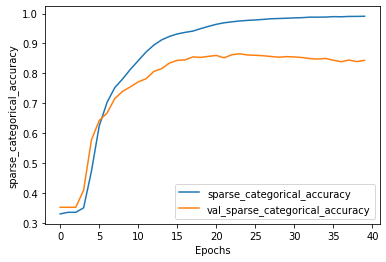

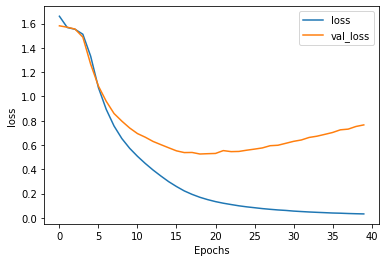

In [13]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "sparse_categorical_accuracy")
plot_graphs(history, "loss")

In [14]:
reverse_word_index = dict([(value, key) for (key, value) in XIndex.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(train_X[0]))
print(tr_sentences[0])
print(tr_labels[0])

i didnt feel humiliated ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
i didnt feel humiliated
sadness


In [15]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(15214, 8)


In [16]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [17]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
reverse_label_index = dict([(value, key) for (key, value) in yIndex.items()])
reverse_label_index

{1: '<oov>',
 2: 'joy',
 3: 'sadness',
 4: 'anger',
 5: 'fear',
 6: 'love',
 7: 'surprise'}

In [20]:
sentence = [
            "im feeling rather rotten so im not very ambitious right now", 
            "i cant walk into a shop anywhere where i do not feel uncomfortable"]
labels = ['sadness','fear']
sequences = tokenizerX.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=padding_type)
predictions = model.predict(padded)
pred_y = [np.argmax(p) for p in predictions]
print([reverse_label_index[y] for y in pred_y])

['sadness', 'anger']
